### Imports

In [91]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import math 
import os 

### Visualization Functions

In [92]:
# Function to save and plot SIRV proportions
def save_and_plot_sirv_proportions(S, I, R, X, population, counties, time_periods, output_folder):
    # Load county names
    county_names_path = os.path.join("inputData", "floridaCountyNames.csv")
    county_names_df = pd.read_csv(county_names_path)
    county_names = county_names_df["County"].tolist()

    # Collect SIRV proportions data
    sirv_data = []
    for i in counties:
        for t in time_periods:
            total_population = population[i]
            s_prop = S[i, t].x / total_population if total_population > 0 else 0
            i_prop = I[i, t].x / total_population if total_population > 0 else 0
            r_prop = R[i, t].x / total_population if total_population > 0 else 0
            x_prop = X[i, t].x / total_population if total_population > 0 else 0
            sirv_data.append([i, t, s_prop, i_prop, r_prop, x_prop])
    
    sirv_df = pd.DataFrame(sirv_data, columns=["region", "timePeriod", "S_proportion", "I_proportion", "R_proportion", "X_proportion"])
    sirv_csv_path = os.path.join(output_folder, "sirvProportions.csv")
    sirv_df.to_csv(sirv_csv_path, index=False)
    print(f"SIRV proportions data saved to '{sirv_csv_path}'")

    # Plot SIRV proportions
    num_regions = len(counties)
    rows = min(23, num_regions)
    cols = math.ceil(num_regions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Proportions Over Time for Each County", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    for idx, i in enumerate(counties):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        region_data = sirv_df[sirv_df["region"] == i]
        county_name = county_names[i] if i < len(county_names) else f"Region {i}"
        ax.plot(region_data["timePeriod"], region_data["S_proportion"], label="S", color="blue")
        ax.plot(region_data["timePeriod"], region_data["I_proportion"], label="I", color="red")
        ax.plot(region_data["timePeriod"], region_data["R_proportion"], label="R", color="green")
        ax.plot(region_data["timePeriod"], region_data["X_proportion"], label="V", color="orange")
        ax.set_title(county_name, fontsize=10)
        ax.grid(True)
        
        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Proportion")

        if idx == 0:  # Add legend to the first subplot only
            ax.legend(loc="upper right", fontsize=6)

    plot_path = os.path.join(output_folder, "sirvProportions.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"SIRV proportions plot saved to '{plot_path}'")
    plt.show()

# Function to save decision variables to CSV files
def save_decision_variables(Z, A, S, I, R, X, u, output_folder, time_periods, decision_periods, counties):
    # Save patient transfer data based on binary variable A
    transfer_data = []
    for i in counties:
        for j in counties:
            for t_prime in decision_periods:
                if A[i, j, t_prime].x > 0.5:  # Check if A[i, j, t_prime] is active (binary decision variable)
                    transfer_data.append([i, j, t_prime, int(A[i, j, t_prime].x)])
    transfer_csv_path = os.path.join(output_folder, "transferData.csv")
    transfer_df = pd.DataFrame(transfer_data, columns=["fromRegion", "toRegion", "timePeriod", "transferIndicator"])
    transfer_df.to_csv(transfer_csv_path, index=False)
    print(f"Patient transfer data saved to '{transfer_csv_path}'")

    # Save actual patient movement quantities in Z
    travel_data = []
    for i in counties:
        for j in counties:
            for t_prime in decision_periods:
                quantity = Z[i, j, t_prime].x
                if quantity > 0:
                    travel_data.append([i, j, t_prime, quantity])
    travel_csv_path = os.path.join(output_folder, "travelData.csv")
    travel_df = pd.DataFrame(travel_data, columns=["fromRegion", "toFacility", "timePeriod", "quantity"])
    travel_df.to_csv(travel_csv_path, index=False)
    print(f"Travel data saved to '{travel_csv_path}'")

    # Save vaccine administration data
    vaccine_admin_data = []
    for i in counties:
        for t in time_periods:
            quantity = X[i, t].x
            if quantity > 0:
                vaccine_admin_data.append([i, t, quantity])
    vaccine_admin_csv_path = os.path.join(output_folder, "vaccineAdminData.csv")
    vaccine_admin_df = pd.DataFrame(vaccine_admin_data, columns=["region", "timePeriod", "administeredVaccines"])
    vaccine_admin_df.to_csv(vaccine_admin_csv_path, index=False)
    print(f"Vaccine administration data saved to '{vaccine_admin_csv_path}'")

    # Save SIRV data
    save_variable_to_csv(S, "S", "susceptibleData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(I, "I", "infectedData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(R, "R", "recoveredData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(X, "X", "vaccinatedData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(u, "u", "unmetDemandData.csv", output_folder, counties, decision_periods)

# Helper function to save each variable to CSV
def save_variable_to_csv(var, var_name, file_name, output_folder, counties, time_periods):
    data = []
    for i in counties:
        for t in time_periods:
            data.append([i, t, var[i, t].x])
    df = pd.DataFrame(data, columns=["region", "timePeriod", var_name])
    path = os.path.join(output_folder, file_name)
    df.to_csv(path, index=False)
    print(f"{var_name} data saved to '{path}'")

# Function to plot unmet demand
def plot_unmet_demand(u, decision_periods, counties):
    unmet_demand = [sum(u[i, t_prime].x for i in counties) for t_prime in decision_periods]
    plt.figure(figsize=(10, 6))
    plt.plot(decision_periods, unmet_demand, marker='o', linestyle='-', color='b')
    plt.title("Total Unmet Healthcare Demand Over Time")
    plt.xlabel("Time Period (weeks)")
    plt.ylabel("Total Unmet Demand (individuals)")
    plt.grid(True)
    plt.xticks(decision_periods)
    plt.show()


### Run the Model (Travel Constraints Not Working)

In [93]:
# Load data files
distanceDF = pd.read_csv("inputData/Sorted_Distance.csv", header=None)   # Distance between counties (d_{ij})
capacityDF = pd.read_csv("inputData/Capacity.csv", header=None)          # Healthcare facility capacities (C_i)
populationDF = pd.read_csv("inputData/Population.csv", header=None)      # Population per county (N_i)

# Model parameters
n = 67  # Number of counties
t_B, t_E = 0, 52  # Start and end of time periods
psi = 2  # Decision-making interval (ψ)
D = 100  # Maximum allowable distance for patient allocation (D)
M = 1e6  # Big-M for binary constraints (M)

# Sets
counties = range(n)
time_periods = range(t_B, t_E + 1, )
decision_periods = range(t_B, t_E + 1, psi)

# Parameters from files and default values
N = {i: populationDF.iloc[i, 0] for i in counties}  # N_i
C = {i: capacityDF.iloc[i, 0] for i in counties}    # C_i
d = {(i, j): distanceDF.iloc[i, j] for i in counties for j in counties}  # d_{ij}

# Infection, recovery, vaccination, and immunity loss rates
beta = {i: 0.5 for i in counties}       # β_i transmission rate 
gamma = {i: 0.75 for i in counties}     # γ_i Recovery rate
lambda_ = {i: 0.25 for i in counties}   # λ_i Rate of vaccination
q = {i: 0.0 for i in counties}         # q_i Rate at which natural immunity is lost
omega = {i: 0.0 for i in counties}     # ω_i Rate at which vaccine-based immunity is lost
ell = {i: 0.005 for i in counties}      # ℓ_i Rate at which vaccine is ineffective
alpha = {(i, t): 0.025 for i in counties for t in time_periods}  # α_i^t

# Initial values for SIRV model (absolute counts)
initial_S_fraction = 0.75
initial_I_fraction = 0.25
initial_R_fraction = 0.00
initial_X_fraction = 0.00

initial_S = {i: initial_S_fraction * N[i] for i in counties}  # Initial susceptible count
initial_I = {i: initial_I_fraction * N[i] for i in counties}  # Initial infected count
initial_R = {i: initial_R_fraction * N[i] for i in counties}  # Initial recovered count
initial_X = {i: initial_X_fraction * N[i] for i in counties}  # Initial vaccinated count

# Initialize Gurobi model
model = gp.Model("Simplified_Linearized_Model")

# Decision Variables
S = model.addVars(counties, time_periods, name="S", vtype=GRB.CONTINUOUS)      # S_i^t
I = model.addVars(counties, time_periods, name="I", vtype=GRB.CONTINUOUS)      # I_i^t
R = model.addVars(counties, time_periods, name="R", vtype=GRB.CONTINUOUS)      # R_i^t
X = model.addVars(counties, time_periods, name="V", vtype=GRB.CONTINUOUS)      # V_i^t
u = model.addVars(counties, decision_periods, name="u", vtype=GRB.CONTINUOUS)  # u_i^{t'}
Z = model.addVars(counties, counties, decision_periods, name="Z", vtype=GRB.CONTINUOUS)  # Z_{ij}^{t'}
phi = model.addVars(counties, decision_periods, name="phi", vtype=GRB.CONTINUOUS)  # φ_i^{t'}
A = model.addVars(counties, counties, decision_periods, name="A", vtype=GRB.BINARY)  # A_{ij}^{t'}
Y = model.addVars(counties, time_periods, name="Y", vtype=GRB.CONTINUOUS)      # Auxiliary for Y_i^t
W = model.addVars(counties, time_periods, name="W", vtype=GRB.CONTINUOUS)      # Auxiliary for W_i^t

# Objective Function (Corresponds to Objective Function in the math model)
model.setObjective(gp.quicksum(u[i, t_prime] for i in counties for t_prime in decision_periods) / n, GRB.MINIMIZE)

# Constraints
for i in counties:
    for t in time_periods:
        if t + 1 <= t_E:
            if t == t_B:
                model.addConstr(S[i, t] == initial_S[i])
                model.addConstr(I[i, t] == initial_I[i])
                model.addConstr(R[i, t] == initial_R[i])
                model.addConstr(X[i, t] == initial_X[i])
            
            else:
                # Susceptible population update (Constraint 1)
                model.addConstr(
                    S[i, t+1] == S[i, t] - beta[i] * Y[i, t] / N[i] - lambda_[i] * S[i, t] 
                    + omega[i] * X[i, t] + q[i] * R[i, t],
                    name=f"S_constraint_{i}_{t}"
                )
                
                # Infected population update (regular periods) (Constraint 2)
                model.addConstr(
                    I[i, t+1] == I[i, t] + beta[i] * Y[i, t] / N[i] + beta[i] * ell[i] * X[i, t]
                    - gamma[i] * I[i, t],
                    name=f"I_constraint_{i}_{t}"
                )
                
                # Recovered population update (Constraint 4)
                model.addConstr(
                    R[i, t+1] == R[i, t] + gamma[i] * I[i, t] - q[i] * R[i, t],
                    name=f"R_constraint_{i}_{t}"
                )
                
                # Vaccinated population update (Constraint 5)
                model.addConstr(
                    X[i, t+1] == X[i, t] + lambda_[i] * S[i, t] - omega[i] * X[i, t] 
                    - beta[i] * ell[i] * W[i, t] / N[i],
                    name=f"V_constraint_{i}_{t}"
                )
    
    for t_prime in decision_periods:
        if t_prime + 1 <= t_E:
            # Infected population update at decision periods (Constraint 3)
            model.addConstr(
                I[i, t_prime+1] == I[i, t_prime] + beta[i] * Y[i, t_prime] / N[i] + beta[i] * ell[i] * X[i, t_prime]
                - gamma[i] * I[i, t_prime] + gp.quicksum(Z[j, i, t_prime] - Z[i, j, t_prime] for j in counties if j != i),
                name=f"I_decision_constraint_{i}_{t_prime}"
            )
        
        # Unmet demand constraint (Constraint 6)
        model.addConstr(
            u[i, t_prime] == gp.quicksum(alpha[i, t] * I[i, t] for t in range(max(t_B, t_prime - psi + 1), t_prime + 1))
            + gp.quicksum(Z[j, i, t_prime] - Z[i, j, t_prime] for j in counties if j != i) - phi[i, t_prime],
            name=f"unmet_demand_constraint_{i}_{t_prime}"
        )
        
        # Satisfied demand constraint (Constraint 7)
        model.addConstr(phi[i, t_prime] <= gamma[i] * C[i], name=f"satisfied_demand_constraint_{i}_{t_prime}")
        
        for j in counties:
            if i != j:
                # Patient transfer constraints
                # Constraint 8: Z_{ij}^{t'} ≤ M * A_{ij}^{t'}
                model.addConstr(Z[i, j, t_prime] <= M * A[i, j, t_prime], name=f"patient_transfer_constraint_{i}_{j}_{t_prime}")
                # Constraint 9: A_{ij}^{t'} * d_{ij} ≤ D
                model.addConstr(A[i, j, t_prime] * d[i, j] <= D, name=f"distance_constraint_{i}_{j}_{t_prime}")
                # Constraint 10: Z_{ij}^{t'} ≥ A_{ij}^{t'}
                model.addConstr(Z[i, j, t_prime] >= A[i, j, t_prime], name=f"binary_transfer_constraint_{i}_{j}_{t_prime}")
    
# Auxiliary constraints for Y_i^t (Constraint 11)
for i in counties:
    for t in time_periods:
        # Y_i^t ≥ 0
        model.addConstr(Y[i, t] >= 0, name=f"Y_positive_constraint_{i}_{t}")
        # Y_i^t ≥ N_i * S_i^t + N_i * I_i^t - N_i^2
        model.addConstr(Y[i, t] >= N[i] * S[i, t] + N[i] * I[i, t] - N[i] ** 2, name=f"Y_lower_bound_{i}_{t}")
        # Y_i^t ≤ N_i * S_i^t
        model.addConstr(Y[i, t] <= N[i] * S[i, t], name=f"Y_upper_S_constraint_{i}_{t}")
        # Y_i^t ≤ N_i * I_i^t
        model.addConstr(Y[i, t] <= N[i] * I[i, t], name=f"Y_upper_I_constraint_{i}_{t}")
        
        # Auxiliary constraints for W_i^t (Constraint 12)
        # W_i^t ≥ 0
        model.addConstr(W[i, t] >= 0, name=f"W_positive_constraint_{i}_{t}")
        # W_i^t ≥ N_i * V_i^t + N_i * I_i^t - N_i^2
        model.addConstr(W[i, t] >= N[i] * X[i, t] + N[i] * I[i, t] - N[i] ** 2, name=f"W_lower_bound_{i}_{t}")
        # W_i^t ≤ N_i * V_i^t
        model.addConstr(W[i, t] <= N[i] * X[i, t], name=f"W_upper_V_constraint_{i}_{t}")
        # W_i^t ≤ N_i * I_i^t
        model.addConstr(W[i, t] <= N[i] * I[i, t], name=f"W_upper_I_constraint_{i}_{t}")
        
# Non-negativity constraints are implicit in variable definitions in Gurobi (since variables are continuous and default to non-negative)
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 405886 rows, 267330 columns and 1186570 nonzeros
Model fingerprint: 0xfae08e90
Variable types: 146127 continuous, 121203 integer (121203 binary)
Coefficient statistics:
  Matrix range     [1e-06, 1e+06]
  Objective range  [1e-02, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 4e+06]
Presolve removed 334825 rows and 210810 columns
Presolve time: 0.70s
Presolved: 71061 rows, 56520 columns, 203174 nonzeros
Variable types: 37512 continuous, 19008 integer (19008 binary)

Root relaxation: objective 2.797824e-05, 720 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0  

### Plot and Save Results

Patient transfer data saved to 'testOutputData\transferData.csv'
Travel data saved to 'testOutputData\travelData.csv'
Vaccine administration data saved to 'testOutputData\vaccineAdminData.csv'
S data saved to 'testOutputData\susceptibleData.csv'
I data saved to 'testOutputData\infectedData.csv'
R data saved to 'testOutputData\recoveredData.csv'
X data saved to 'testOutputData\vaccinatedData.csv'
u data saved to 'testOutputData\unmetDemandData.csv'


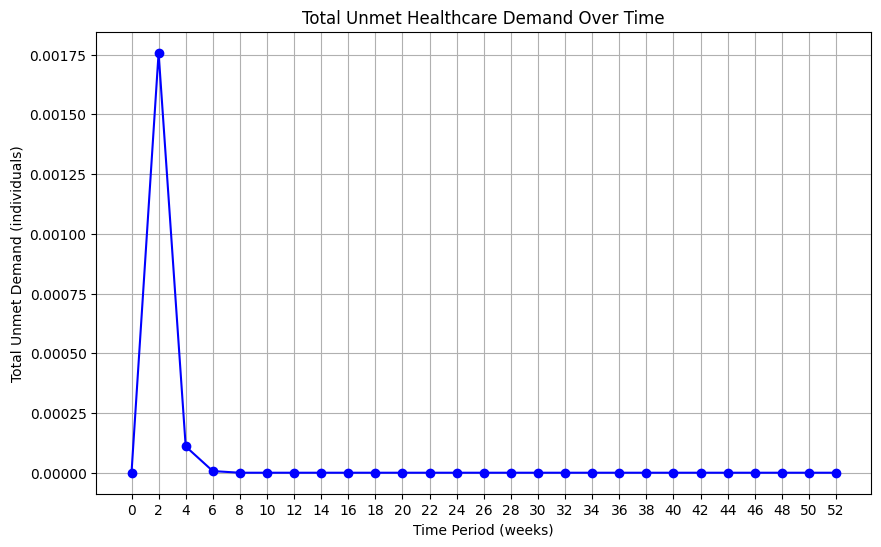

SIRV proportions data saved to 'testOutputData\sirvProportions.csv'
SIRV proportions plot saved to 'testOutputData\sirvProportions.png'


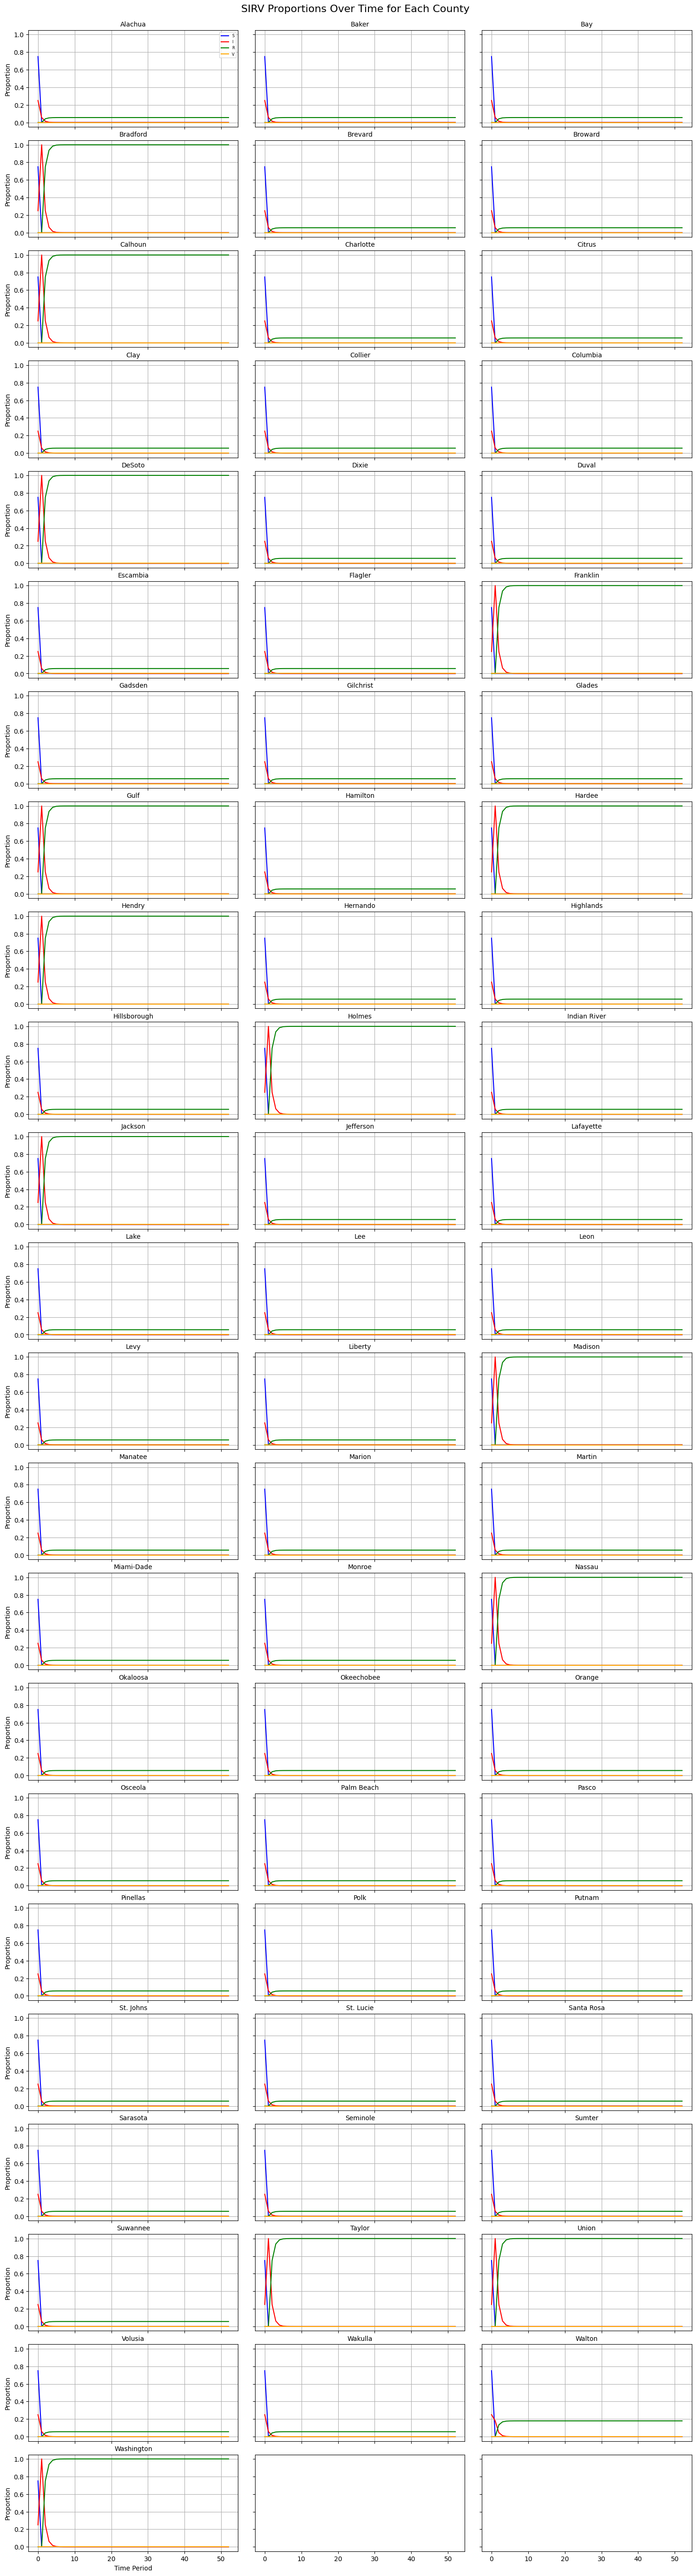

In [94]:
# Ensure the output folder exists
output_folder = "testOutputData"
os.makedirs(output_folder, exist_ok=True)

# Usage after model optimization
if model.status == GRB.OPTIMAL:
    save_decision_variables(Z, A, S, I, R, X, u, output_folder, time_periods, decision_periods, counties) 
    plot_unmet_demand(u, decision_periods, counties)
    save_and_plot_sirv_proportions(S, I, R, X, N, counties, time_periods, output_folder)
else:
    print("Model did not optimize successfully.")
